In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from scipy import stats


In [2]:
# Load the training dataset
df = pd.read_csv("/kaggle/input/playground-series-s4e2/train.csv")

#Print the first few rows of the dataset
print(df.head())

   id  Gender        Age    Height      Weight family_history_with_overweight  \
0   0    Male  24.443011  1.699998   81.669950                            yes   
1   1  Female  18.000000  1.560000   57.000000                            yes   
2   2  Female  18.000000  1.711460   50.165754                            yes   
3   3  Female  20.952737  1.710730  131.274851                            yes   
4   4    Male  31.641081  1.914186   93.798055                            yes   

  FAVC      FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  \
0  yes  2.000000  2.983297   Sometimes    no  2.763573  no  0.000000   
1  yes  2.000000  3.000000  Frequently    no  2.000000  no  1.000000   
2  yes  1.880534  1.411685   Sometimes    no  1.910378  no  0.866045   
3  yes  3.000000  3.000000   Sometimes    no  1.674061  no  1.467863   
4  yes  2.679664  1.971472   Sometimes    no  1.979848  no  1.967973   

        TUE       CALC                 MTRANS           NObeyesdad  
0  0.976473

In [3]:
# Check for missing values
print(df.isnull().sum())

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


In [4]:
# check duplicates
df.duplicated().sum()

0

# EDA

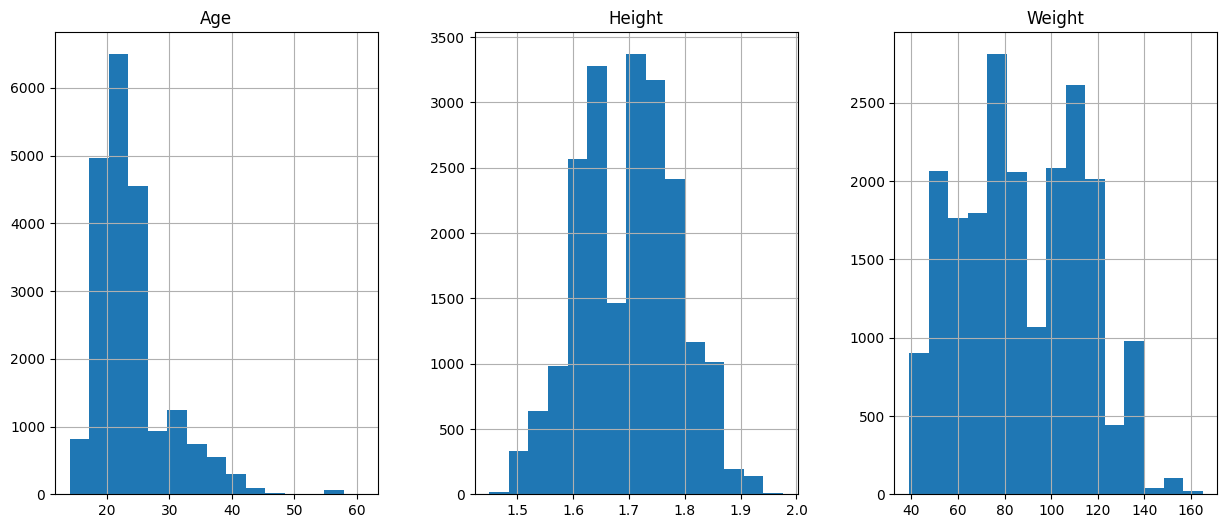

In [5]:
# Histograms for numerical features
df[['Age', 'Height', 'Weight']].hist(bins=15, figsize=(15, 6), layout=(1, 3))
plt.show()


'Age' seems to be right-skewed, 'Height' appears normally distributed, and 'Weight' exhibits a potential multimodal distribution. 

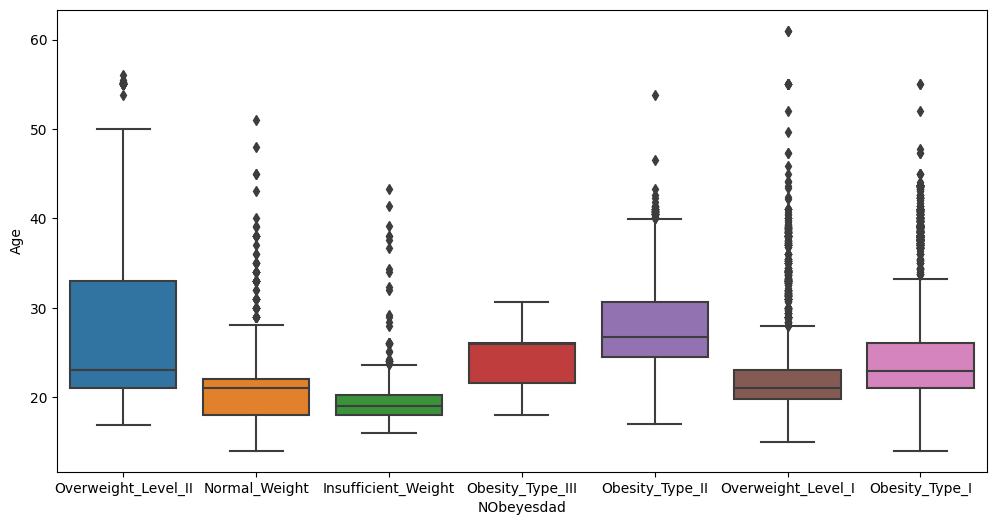

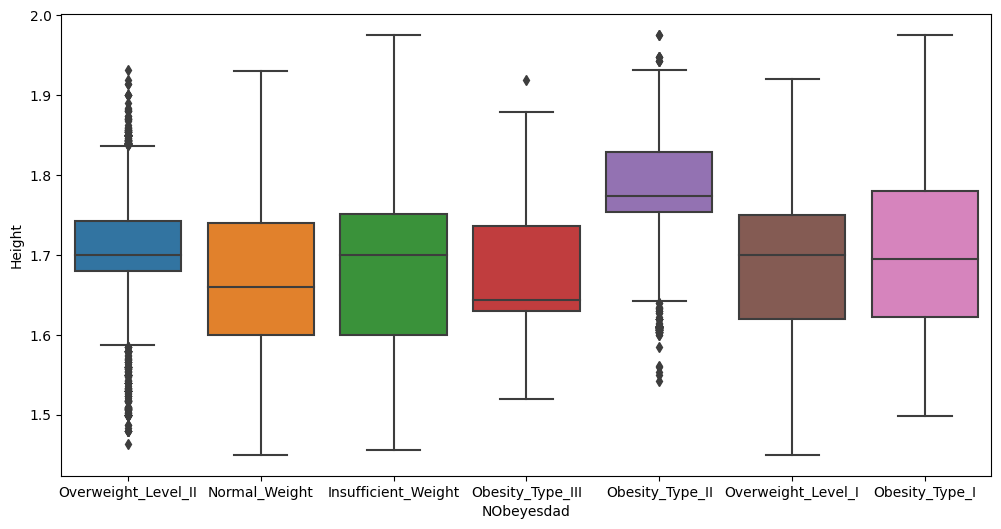

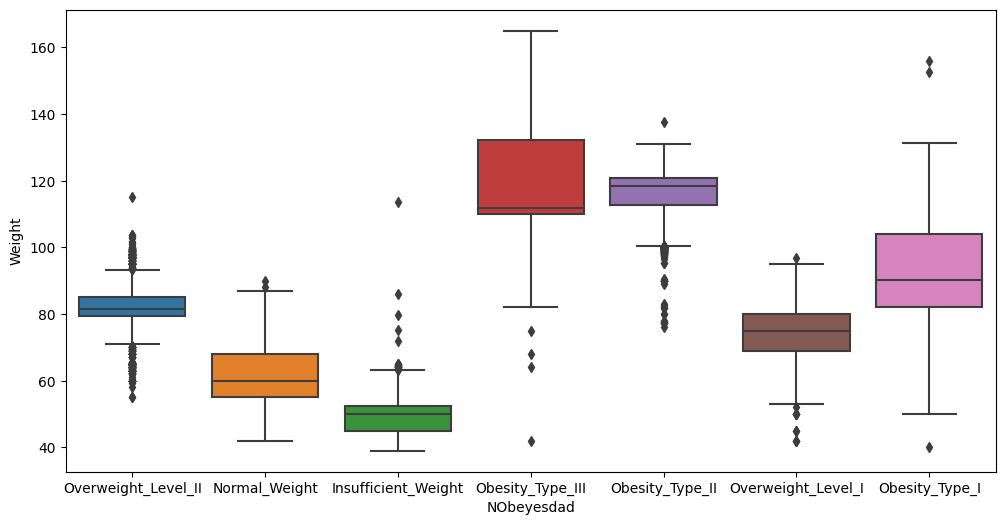

In [6]:
# Boxplots for categorical features vs target
plt.figure(figsize=(12, 6))
sns.boxplot(x='NObeyesdad', y='Age', data=df)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='NObeyesdad', y='Height', data=df)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='NObeyesdad', y='Weight', data=df)
plt.show()

The boxplots indicate that there are differences in the distribution of 'Age', 'Height', and 'Weight' across the different categories of 'NObeyesdad', which is promising for using these features to predict obesity levels.

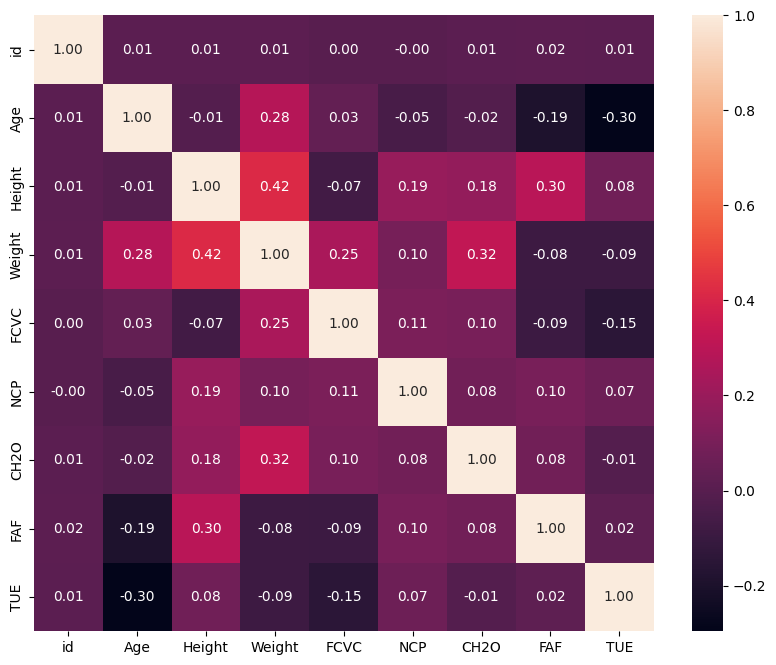

In [7]:
# Heatmap for numerical features

#selecting numerical columns
numerical_df = df.select_dtypes(include=['float64', 'int64'])

#heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_df.corr(), annot=True, fmt=".2f")
plt.show()

The heatmap shows some variables are more correlated with each other than the rest. Notably, 'Height' and 'Weight' have a strong positive correlation, which is intuitive.  

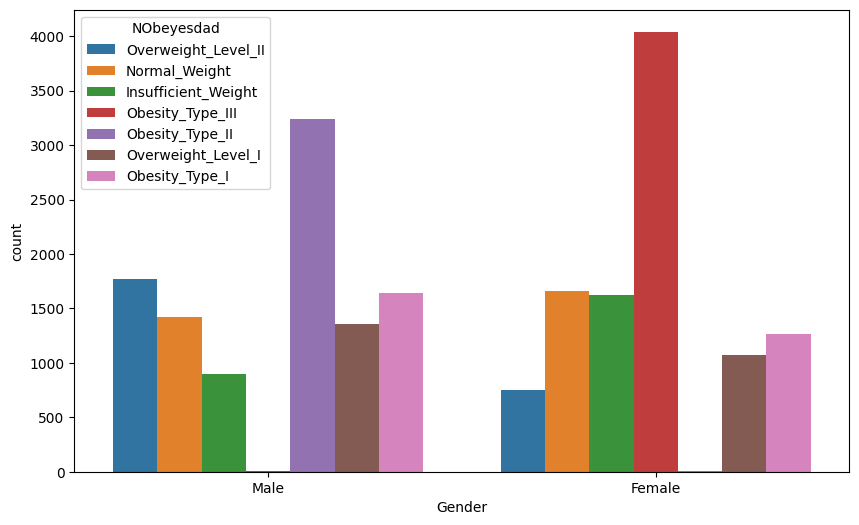

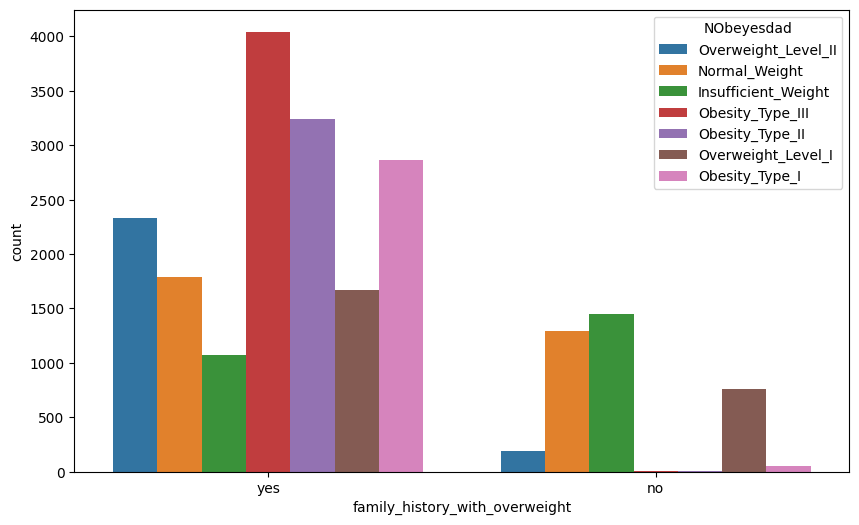

In [8]:
# Count plots for categorical features
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', hue='NObeyesdad', data=df)
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='family_history_with_overweight', hue='NObeyesdad', data=df)
plt.show()

These features seem to have different distributions for the different obesity levels, which could be useful predictors.

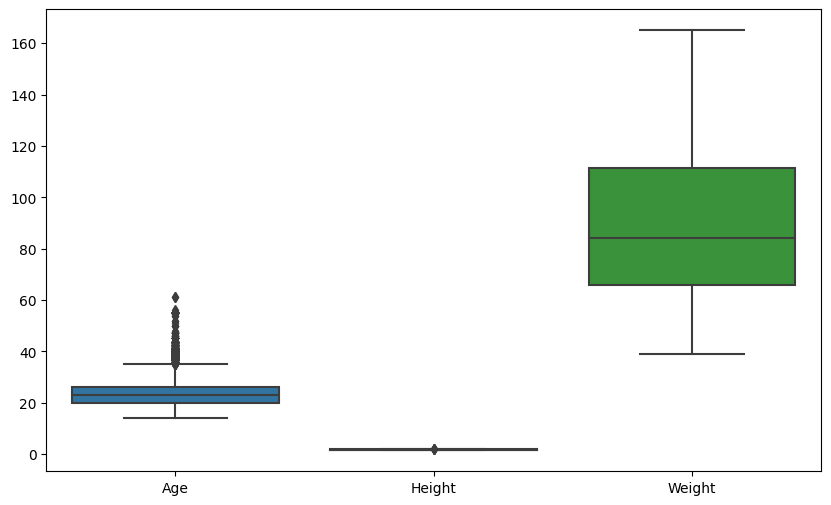

In [9]:
# Box plot for numerical features
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['Age', 'Height', 'Weight']])
plt.show()

In [10]:
def impute_outliers_with_median(dataframe, column):

    """Impute outliers using median of the column."""

    col_median = dataframe[column].median()

    Q1 = dataframe[column].quantile(0.25)

    Q3 = dataframe[column].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR

    upper_bound = Q3 + 1.5 * IQR

    

    # Outlier conditions

    outliers_lower = dataframe[column] < lower_bound

    outliers_upper = dataframe[column] > upper_bound

    

    # Impute outliers with median

    dataframe[column] = dataframe[column].mask(outliers_lower | outliers_upper, col_median, axis=0)

    return dataframe



# Apply the function to the 'Age', 'Height', and 'Weight' columns

df = impute_outliers_with_median(df, 'Age')

df = impute_outliers_with_median(df, 'Height')

df = impute_outliers_with_median(df, 'Weight')



# Displaying the results for the 'Age', 'Height', and 'Weight' columns to confirm if outliers have been imputed

df.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,22.945976,1.700192,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.46278,4.101315,0.087228,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.75000,25.957740,1.762515,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.00000,35.000000,1.947406,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


Age: The minimum age is 14, which seems reasonable. The maximum age is 35, which is within a typical range for a study population.

Height: The minimum height is 1.45 meters, and the maximum is 1.95 meters. Both are within plausible ranges for human height.

Weight: The minimum weight is 39 kg, and the maximum is 165 kg. These values are on the lower and higher ends of the weight spectrum but can be considered realistic.